In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import itertools
import sklearn
import sklearn.datasets
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import knn

In [ ]:
# cluster = (np.arange(1000) < 500).astype(int)
# cov1 = [[1, 0.5], [0.5, 1]]
# cov2 = [[1, -0.5], [-0.5, 1]]
# X1 = scipy.stats.multivariate_normal(mean=[0, -4], cov=cov1).rvs(500)
# X2 = scipy.stats.multivariate_normal(mean=[0, +4], cov=cov2).rvs(500)
# X = np.vstack([X1, X2])
# X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# X = np.hstack([X, cluster.reshape(-1, 1)])
# X.shape

In [ ]:
cluster = (np.arange(4000) < 3000).astype(int)
X1 = scipy.stats.multivariate_normal(mean=[+8, 0], cov=np.eye(2)).rvs(1000)
X2 = scipy.stats.multivariate_normal(mean=[-8, 0], cov=np.eye(2)).rvs(1000)
X3 = scipy.stats.multivariate_normal(mean=[0, +8], cov=np.eye(2)).rvs(1000)
X4 = scipy.stats.multivariate_normal(mean=[0, -8], cov=np.eye(2)).rvs(1000)
X = np.vstack([X1, X2, X3, X4])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X = np.hstack([X, cluster.reshape(-1, 1)])
X.shape

In [ ]:
sns.pairplot(pd.DataFrame(X), hue=2)
plt.savefig('output/pair-gmm.pdf', format='pdf')

In [ ]:
n, d = X.shape
edges = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray().astype(float)

In [ ]:
gl = sklearn.covariance.GraphLassoCV(assume_centered=True)
gl.fit(X)
corr = gl.precision_
corr = corr / np.sqrt(np.diag(corr)).reshape(1, -1) / np.sqrt(np.diag(corr)).reshape(-1, 1)

In [ ]:
ground_truth = np.ones([3, 3], dtype=float)
ground_truth[0, 2] = ground_truth[2, 0] = 0
ground_truth[np.eye(3, dtype=bool)] = None
corr[np.eye(3, dtype=bool)] = None
adj[np.eye(3, dtype=bool)] = None

f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('Ground truth', fontsize=15)
axes[1].set_title('Graphical lasso (CV)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$']
sns.heatmap(ground_truth, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(corr, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-gmm.pdf', format='pdf')

In [ ]:
def heat_mi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        mis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            x = X[:, [i]]
            y = X[:, [j]]
            mis[i, j] = knn.mi_knn(x, y, k=3)

        mis[mis < 0] = 0
        mis[np.eye(d, dtype=bool)] = None
        sns.heatmap(mis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

def heat_cmi(X, ks=[3, 5, 15]):
    m = len(ks)
    f, axes = plt.subplots(1, m, figsize=[3 * m + 1, 3])
    n, d = X.shape
    for l, k in enumerate(ks):
        cmis = np.eye(d)
        for i, j in [(i, j) for i in range(d) for j in range(d) if i != j]:
            x = X[:, [i]]
            y = X[:, [j]]
            z = X[:, (np.arange(d) != i) & (np.arange(d) != j)]
            cmis[i, j] = knn.cmi_knn(x, y, z, k=k)

        cmis[cmis < 0] = 0
        cmis[np.eye(d, dtype=bool)] = None
        sns.heatmap(cmis, annot=True, ax=axes[l], center=0, cmap=palette, cbar=False)

In [ ]:
heat_cmi(X)

In [2]:
df = pd.read_csv('data/stock1.csv', index_col=0)
df.columns = pd.read_csv('data/stock2.csv', index_col=0).values[:, 0]
df = df[df.columns[4:9]]
# df = df[df.columns[25:30]] # よさげ
X = df.values
X = sklearn.preprocessing.scale(X)
df[:5]

,ADBE,AMD,AES,AET,AFL
1,25.60,7.01,3.24,42.04,31.59
2,26.30,6.94,3.45,42.33,31.60
3,27.51,7.16,3.45,42.75,32.00
4,28.51,7.17,3.37,42.18,31.73
5,27.13,6.69,3.35,42.23,31.80


In [ ]:
sns.pairplot(df.sample(300))
plt.tight_layout()
plt.savefig('output/pair-stock.pdf', format='pdf')

In [4]:
n, d = X.shape
edges = knn.learn_mrf(X)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray().astype(float)
adj[np.eye(5, dtype=bool)] = None

In [3]:
# gl = sklearn.covariance.GraphLasso(alpha=0.14, assume_centered=True)
gl = sklearn.covariance.GraphLasso(alpha=0.1, assume_centered=True)
gl2 = sklearn.covariance.GraphLassoCV(assume_centered=True)
gl.fit(X)
gl2.fit(X)
corr = gl.precision_
corr = corr / np.sqrt(np.diag(corr)).reshape(1, -1) / np.sqrt(np.diag(corr)).reshape(-1, 1)
corr2 = gl2.precision_
corr2 = corr2 / np.sqrt(np.diag(corr2)).reshape(1, -1) / np.sqrt(np.diag(corr2)).reshape(-1, 1)
corr[np.eye(5, dtype=bool)] = None
corr2[np.eye(5, dtype=bool)] = None

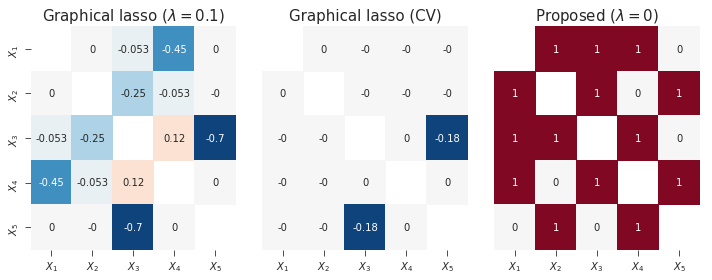

In [5]:
f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('Graphical lasso ($\lambda = 0.1$)', fontsize=15)
axes[1].set_title('Graphical lasso (CV)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
sns.heatmap(corr, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(corr2, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-stock.pdf', format='pdf')

In [ ]:
data = sklearn.datasets.load_iris()
df = pd.DataFrame(data['data'], columns=list(data.feature_names))
df['class'] = data.target
df[:5]
X = df.values

In [ ]:
n, d = X.shape
edges = knn.learn_mrf(X, alpha=0.1)
g = nx.Graph()
g.add_nodes_from(range(d))
g.add_edges_from(edges)
adj = nx.adjacency_matrix(g).toarray()

In [ ]:
# gl = sklearn.covariance.GraphLasso(alpha=0.14, assume_centered=True)
gl = sklearn.covariance.GraphLasso(alpha=0.1, assume_centered=True)
gl2 = sklearn.covariance.GraphLassoCV(assume_centered=True)
gl.fit(X)
gl2.fit(X)
corr = gl.precision_
corr = corr / np.sqrt(np.diag(corr)).reshape(1, -1) / np.sqrt(np.diag(corr)).reshape(-1, 1)
corr2 = gl2.precision_
corr2 = corr2 / np.sqrt(np.diag(corr2)).reshape(1, -1) / np.sqrt(np.diag(corr2)).reshape(-1, 1)
corr[np.eye(5, dtype=bool)] = None
corr2[np.eye(5, dtype=bool)] = None

In [ ]:
f, axes = plt.subplots(1, 3, figsize=[10, 4])
axes[0].set_title('Graphical lasso ($\lambda = 0.1$)', fontsize=15)
axes[1].set_title('Graphical lasso (CV)', fontsize=15)
axes[2].set_title('Proposed ($\lambda = 0.1$)', fontsize=15)
labels = ['$X_1$', '$X_2$', '$X_3$', '$X_4$', '$X_5$']
sns.heatmap(corr, annot=True, center=0, ax=axes[0], cmap=palette, cbar=False, xticklabels=labels, yticklabels=labels)
sns.heatmap(corr2, annot=True, center=0, ax=axes[1], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
sns.heatmap(adj, annot=True, center=0, ax=axes[2], cmap=palette, cbar=False, xticklabels=labels, yticklabels=[])
plt.tight_layout()
plt.savefig('output/heat-iris.pdf', format='pdf')